# Calcul du tenseur d'Eshelby dans le cas des ellipses

## 0 Quelques fonctions utiles

In [3]:
import numpy as np
from numpy import pi
from numpy.random import random_sample
from numpy.linalg import inv
from numpy import dot
from scipy.spatial.transform import Rotation as Rot
from classes_v2 import *

def Comp3333_to_66 (G) : 
    "Passe d'un tenseur de comportement  G 3x3x3x3 a une matrice de comportement F 6x6"
    F=np.zeros((6,6))
    for i in range(3):
        for j in range(3):
            F[i,j] = G[i,i,j,j]
            
        F[i,5]=(G[i,i,0,1]+G[i,i,1,0])/2.
        F[i,3]=(G[i,i,1,2]+G[i,i,2,1])/2. 
        F[i,4]=(G[i,i,2,0]+G[i,i,0,2])/2. 
        F[3,i]=(G[1,2,i,i]+G[2,1,i,i])/2. 
        F[4,i]=(G[0,2,i,i]+G[2,0,i,i])/2.
        F[5,i]=(G[0,1,i,i]+G[1,0,i,i])/2.

    F[4,4]=(G[0,2,0,2]+G[2,0,0,2]+G[0,2,2,0]+G[2,0,2,0])/4. 
    F[3,3]=(G[1,2,1,2]+G[2,1,1,2]+G[1,2,2,1]+G[2,1,2,1])/4.  
    F[5,5]=(G[0,1,0,1]+G[1,0,0,1]+G[0,1,1,0]+G[1,0,1,0])/4.  
    F[4,3]=(G[0,2,1,2]+G[2,0,1,2]+G[0,2,2,1]+G[2,0,2,1])/4.  
    F[4,5]=(G[0,2,1,0]+G[2,0,1,0]+G[0,2,0,1]+G[2,0,0,1])/4.  
    F[3,4]=(G[1,2,0,2]+G[2,1,0,2]+G[1,2,2,0]+G[2,1,2,0])/4.  
    F[5,4]=(G[0,1,0,2]+G[1,0,0,2]+G[0,1,2,0]+G[1,0,2,0])/4.  
    F[3,5]=(G[1,2,1,0]+G[2,1,1,0]+G[1,2,0,1]+G[2,1,0,1])/4.   
    F[5,3]=(G[0,1,1,2]+G[1,0,1,2]+G[0,1,2,1]+G[1,0,2,1])/4. 
    
    return F

def Comp66_to_3333(F) : 
    'Passe d une matrice F 6x6 à un tenseur G 3x3x3x3'
    G = np.zeros((3,3,3,3))
    for i in range(3) :
        for j in range(3) :
            G[i,i,j,j]=F[i,j]
       
        G[i,i,0,1]=F[i,5]
        G[i,i,1,2]=F[i,3]
        G[i,i,2,0]=F[i,4]
        G[0,2,i,i]=F[4,i]
        G[1,2,i,i]=F[3,i]
        G[0,1,i,i]=F[5,i]
        G[i,i,1,0]=F[i,5]
        G[i,i,2,1]=F[i,3]
        G[i,i,0,2]=F[i,4]
        G[2,0,i,i]=F[4,i]
        G[2,1,i,i]=F[3,i]
        G[1,0,i,i]=F[5,i]
        
    G[0,1,0,1]=F[5,5]
    G[0,1,0,2]=F[5,4]
    G[0,1,1,0]=F[5,5]
    G[0,1,1,2]=F[5,3] 
    G[0,1,2,0]=F[5,4]
    G[0,1,2,1]=F[5,3]

    G[0,2,0,1]=F[4,5]
    G[0,2,0,2]=F[4,4]
    G[0,2,1,0]=F[4,5]
    G[0,2,1,2]=F[4,3] 
    G[0,2,2,0]=F[4,4]
    G[0,2,2,1]=F[4,3]

    G[1,0,0,1]=F[5,5]
    G[1,0,0,2]=F[5,4]
    G[1,0,1,0]=F[5,5]
    G[1,0,1,2]=F[5,3] 
    G[1,0,2,0]=F[5,4]
    G[1,0,2,1]=F[5,3]

    G[1,2,0,2]=F[3,4]
    G[1,2,1,0]=F[3,5]
    G[1,2,1,2]=F[3,3] 
    G[1,2,2,0]=F[3,4]
    G[1,2,2,1]=F[3,3]

    G[2,0,0,1]=F[4,5]
    G[2,0,0,2]=F[4,4]
    G[2,0,1,0]=F[4,5]
    G[2,0,1,2]=F[4,3] 
    G[2,0,2,0]=F[4,4]
    G[2,0,2,1]=F[4,3]

    G[2,1,0,1]=F[3,5]
    G[2,1,0,2]=F[3,4]
    G[2,1,1,0]=F[3,5]
    G[2,1,1,2]=F[3,3] 
    G[2,1,2,0]=F[3,4]
    G[2,1,2,1]=F[3,3]
 
    return G 

def Rotation_angles():
    theta = 2*pi*np.random.random()
    psi = 2*pi*np.random.random()
    phi = np.arccos(np.random.random())
    return (phi,theta,psi)


def Matrice_rotation(psi,phi,theta) : 
    'Crée une matrice de rotation 3x3 à partir des trois angles d euler'
    Q = np.zeros((3,3))
    
    Q[0,0]=cos(psi)*cos(theta)-cos(phi)*sin(theta)*sin(psi)
    Q[0,1]=sin(theta)*cos(psi)+cos(phi)*sin(psi)*cos(theta)
    Q[0,2]=sin(phi)*sin(psi)
    Q[1,0]=-sin(psi)*cos(theta)-sin(theta)*cos(phi)*cos(psi)
    Q[1,1]=cos(psi)*cos(phi)*cos(theta)-sin(theta)*sin(psi)
    Q[1,2]=cos(psi)*sin(phi)
    Q[2,0]=sin(phi)*sin(theta)
    Q[2,1]=-sin(phi)*cos(theta)
    Q[2,2]=cos(phi)
    
    for i in range(3) : 
        for j in range(3):
            if (abs(Q[i,j]) < 10**-6 ) :
                Q[i,j] = 0
            
    return Q

def Matrices_rotation(n) : 
    'Crée une matrice de rotation 3x3 à partir des trois angles d euler'
    Q = np.zeros((n,3,3))
    for i in range(n) : 
        theta,phi,psi = Rot.random().as_euler('zxy', degrees=False)
        Q[i,0,0]=cos(psi)*cos(theta)-cos(phi)*sin(theta)*sin(psi)
        Q[i,0,1]=sin(theta)*cos(psi)+cos(phi)*sin(psi)*cos(theta)
        Q[i,0,2]=sin(phi)*sin(psi)
        Q[i,1,0]=-sin(psi)*cos(theta)-sin(theta)*cos(phi)*cos(psi)
        Q[i,1,1]=cos(psi)*cos(phi)*cos(theta)-sin(theta)*sin(psi)
        Q[i,1,2]=cos(psi)*sin(phi)
        Q[i,2,0]=sin(phi)*sin(theta)
        Q[i,2,1]=-sin(phi)*cos(theta)
        Q[i,2,2]=cos(phi)
    
        for j in range(3) : 
            for k in range(3):
                if (abs(Q[i,j,k]) < 10**-6 ) :
                    Q[i,j,k] = 0
            
    return Q

def Rotation_operator(n_renforts) : 
    B = np.zeros((n_renforts,3,3,3,3,3,3,3,3))
    R = np.zeros((n_renforts,3,3))
    for z in range(n_renforts) :
        theta,phi,psi = Rot.random().as_euler('zxy', degrees=False)
        R[z,0,0]=cos(psi)*cos(theta)-cos(phi)*sin(theta)*sin(psi)
        R[z,0,1]=sin(theta)*cos(psi)+cos(phi)*sin(psi)*cos(theta)
        R[z,0,2]=sin(phi)*sin(psi)
        R[z,1,0]=-sin(psi)*cos(theta)-sin(theta)*cos(phi)*cos(psi)
        R[z,1,1]=cos(psi)*cos(phi)*cos(theta)-sin(theta)*sin(psi)
        R[z,1,2]=cos(psi)*sin(phi)
        R[z,2,0]=sin(phi)*sin(theta)
        R[z,2,1]=-sin(phi)*cos(theta)
        R[z,2,2]=cos(phi)
        for  i in range(3) : 
            for  j in range(i+1):
                for  k in range(3):
                    for  l in range(k+1):
                        for  m in range(3):
                            for  n in range(3):
                                for  ll in range(3):
                                    for  kk in range(3):
                                        B[z,i,j,k,l,m,n,ll,kk] = R[z,i,m]*R[z,j,n]*R[z,k,ll]*R[z,l,kk]
    return B

def Rotation_tenseur(S,R,z) : 
    ' Renvoie la rotation du tenseur S par les 3 angles d Euler'
    B = np.zeros((3,3,3,3))
    for  i in range(3) : 
        for  j in range(i+1):
            for  k in range(3):
                for  l in range(k+1):
                    for  m in range(3):
                        for  n in range(3):
                            for  ll in range(3):
                                for  kk in range(3):
                                    B[i,j,k,l] += R[z,i,m]*R[z,j,n]*R[z,k,ll]*R[z,l,kk]*S[m,n,ll,kk]
                                    B[i,j,l,k] = B[i,j,k,l]
                                    B[j,i,k,l] = B[i,j,k,l]
                                    B[j,i,l,k] = B[i,j,k,l]
    return B

def Rotation_tenseur2(S,Operator,z) : 
    ' Renvoie la rotation du tenseur S par les 3 angles d Euler'
    B = np.zeros((3,3,3,3))
    for  i in range(3) : 
        for  j in range(i+1):
            for  k in range(3):
                for  l in range(k+1):
                    for  m in range(3):
                        for  n in range(3):
                            for  ll in range(3):
                                for  kk in range(3):
                                    B[i,j,k,l] += Operator[z,i,j,k,l,m,n,ll,kk]*S[m,n,ll,kk]
                                    B[i,j,l,k] = B[i,j,k,l]
                                    B[j,i,k,l] = B[i,j,k,l]
                                    B[j,i,l,k] = B[i,j,k,l]
    return B

def Rotation_tenseur3(S,Operator,z,B) : 
    ' Renvoie la rotation du tenseur S par les 3 angles d Euler '
    
    for  i in range(3) : 
        for  j in range(3):
            for  k in range(3):
                for  l in range(3):
                    B[i,j,k,l] = 0
                    
    for  i in range(3) : 
        for  j in range(i+1):
            for  k in range(3):
                for  l in range(k+1):
                    for  m in range(3):
                        for  n in range(3):
                            for  ll in range(3):
                                for  kk in range(3):
                                    B[i,j,k,l] += Operator[z,i,j,k,l,m,n,ll,kk]*S[m,n,ll,kk]
                                    
    for  i in range(3) : 
        for  j in range(i+1):
            for  k in range(3):
                for  l in range(k+1):
                    B[i,j,l,k] = B[i,j,k,l]
                    B[j,i,k,l] = B[i,j,k,l]
                    B[j,i,l,k] = B[i,j,k,l]
    return B


def Matrice_Souplesse_Isotrope(E,nu) :
    'Renvoie la matrice de souplesse d un matériau isotrope'
    S = np.zeros((6,6))
    S[0,0]=1./E
    S[1,1]=1./E
    S[2,2]=1./E

    S[3,3]=2.*(1+nu)/E
    S[4,4]=2.*(1+nu)/E
    S[5,5]=2.*(1+nu)/E

    S[0,1]=-nu/E
    S[0,2]=-nu/E
    S[1,2]=-nu/E
    S[1,0]=-nu/E
    S[2,1]=-nu/E
    S[2,0]=-nu/E
    
    return S
    

def Young_isotrope(S) : 
    return 1/3 * (1/S[0,0]+1/S[1,1]+1/S[2,2])

def nu_isotrope(S) : 
    E = Young_isotrope(S)
    return - 1/3 * E * (S[0,1] +S[0,2] + S[1,2])

def Young_isotropeC(C) : 
    nu = nu_isotropeC(C)
    return 2 * (1+nu) * 1/3 *(C[3,3]+C[4,4]+C[5,5])

def nu_isotropeC(C) : 
    x = (C[0,0]+C[1,1]+C[2,2]) / (C[0,1]+C[0,2]+C[1,2])
    return 1/(1+x)

    
def Young_anisotrope(S) : 
    return 1/S[0,0],1/S[1,1],1/S[2,2]


def Compute_with_permutation(a,I,II,nu) : 
    S = np.zeros((3,3,3,3))
    
    for i in range(3) :
        S[i,i,i,i] = 3*a[i]**2*II[i][i] / (8*pi*(1-nu)) + I[i] * (1-2*nu)/(8*pi*(1-nu))
        j = (i+1)%3
        S[i,i,j,j] = a[j]**2*II[i][j]/(8*pi*(1-nu)) -  I[i] * (1-2*nu)/(8*pi*(1-nu))
        S[i,j,i,j] = (a[i]**2+a[j]**2)*II[i][j]/(16*pi*(1-nu)) + (1-2*nu)/(16*pi*(1-nu))*(I[i]+I[j])
        k = (i+2)%3
        S[i,i,k,k] = a[k]**2*II[i][k]/(8*pi*(1-nu)) -  I[i] * (1-2*nu)/(8*pi*(1-nu))
        S[i,k,i,k] = (a[i]**2+a[k]**2)*II[i][k]/(16*pi*(1-nu)) + (1-2*nu)/(16*pi*(1-nu))*(I[i]+I[k])
        
    return S

def Cyclic_permutation(S) : 
    for i in range(3) : 
        for j in range(3) :
            for k in range(3) : 
                for l in range(3) : 
                    val = non_zeros(S,i,j,k,l)
                    S[i,j,k,l] = val
                    S[i,j,l,k] = val
                    S[j,i,k,l] = val
                    S[j,i,l,k] = val
    return S
                    

def non_zeros(S,i,j,k,l) : 
    if S[i,j,k,l] != 0 : 
        return S[i,j,k,l]
    if S[i,j,l,k] != 0 : 
        return S[i,j,l,k]
    if S[j,i,k,l] != 0 : 
        return S[j,i,k,l]
    if S[j,i,l,k] != 0 : 
        return S[j,i,l,k]
    return 0

def clear_matrix3 (C,k) : 
    n = C.shape[0]
    for i in range(n) : 
        for j in range(n) :
            if C[i,j,k]<10**-8 : 
                C[i,j,k] = 0
                
def clear_matrix2 (C) : 
    n = C.shape[0]
    for i in range(n) : 
        for j in range(n) :
            if C[i,j]<10**-5 : 
                C[i,j] = 0
    

# Calcul du tenseur d'Eshelby dans le cas général

In [4]:
def Eshelby_tensor(Axis,Em,nu) : 
    
    Sm = Matrice_Souplesse_Isotrope(Em,nu)
    Cm = inv(Sm)
    Cm3 = Comp66_to_3333(Cm)
    a0,a1,a2 = Axis
    IJV = np.array([[0,0],[1,1],[2,2],[1,2],[0,2],[0,1]])
    Nit = 40
    Ntop = Nit
    Mtop = Nit
    dphi = pi/(Ntop-1)
    dtheta = pi/(Ntop-1)
    A = np.zeros((6,6))
    B = np.zeros((6,6,Mtop))
    G = np.zeros((6,6,Ntop))
    E = np.zeros((6,6))
    
    # Integration de la fonction de green sur la demi ellipsoïde
    for m in range(Mtop) : 
        phi = m*dphi
        for n in range(Ntop) : 
            theta = n*dtheta
            X = np.array([sin(theta)*cos(phi)/a0 , sin(theta)*sin(phi)/a1 , cos(theta)/a2])
            CXX = np.zeros((3,3))
            for i in range(3) :
                for j in range(3) :
                    for k in range(3) : 
                        for l in range(3) :
                            CXX[i,k] += Cm3[i,j,k,l]*X[j]*X[l]
            #print("CXX" , m,n) 
            #print(CXX) 
            CXX = inv(CXX)
            #print("CXX") 
            #print(CXX) 
            for i in range(6) :
                for j in range(6) :                     
                    I1 = IJV[i,0]
                    J1 = IJV[j,0]
                    I2 = IJV[i,1]
                    J2 = IJV[j,1]
                    G[i,j,n] = 0.5 * sin(theta) * (CXX[I1,J1]*X[I2]*X[J2] + CXX[I2,J1]*X[I1]*X[J2] + CXX[I1,J2]*X[I2]*X[J1] + CXX[I2,J2]*X[I1]*X[J1])
        
        
        B[:,:,m] = 0.5 * dtheta * (G[:,:,0]+G[:,:,Ntop-1])
        for i in range(1,Ntop-1) : 
            B[:,:,m] +=  dtheta * G[:,:,i]

    A = 0.5*(B[:,:,0]+B[:,:,Ntop-1])* dphi/(4*pi)
    for i in range(1,Ntop-1) : 
         A += B[:,:,i]* dphi/(4*pi)  
    
    for i in range(6) : 
        for j in range(6) : 
            E[i,j]=A[i,0]*Cm[0,j]+A[i,1]*Cm[1,j]+A[i,2]*Cm[2,j] + 4* (A[i,3]*Cm[3,j]+A[i,4]*Cm[4,j]+A[i,5]*Cm[5,j]) 
    
    return E

In [5]:
E = Eshelby_tensor((1,1,1),1,0)
clear_matrix2(E)
print(E)

[[0.46666702 0.         0.         0.         0.         0.        ]
 [0.         0.46666702 0.         0.         0.         0.        ]
 [0.         0.         0.46612587 0.         0.         0.        ]
 [0.         0.         0.         0.53279201 0.         0.        ]
 [0.         0.         0.         0.         0.53279201 0.        ]
 [0.         0.         0.         0.         0.         0.53333369]]


## MODELE AUTOCOHERENT UNE FORME D'INCLUSION

In [6]:
from scipy.spatial.transform import Rotation as Rot
import time as tm
        
def compute_h_behavior(A,f):
    
    n_renforts = 500     # paramètre non physique qui permet de forcer lisotropie
    n_pas = 80            # pas du modèle autocohérent
    precision = 10**-2  # précision désirée dans l'algorithme du point fixe
    

    # Création des matrices de comportement
    Em = 1
    num = 0.3
    Ef = 100
    nuf = 0.3
    
    Sm = Matrice_Souplesse_Isotrope(Em,num)
    Cm = inv(Sm)
    Sf = Matrice_Souplesse_Isotrope(Ef,nuf)
    Cf = inv(Sf)    
    Id = np.identity(6)
    
    #Création des matrices de rotations
    MRot = Matrices_rotation(n_renforts)
    
    # Création des liste de résultat
    listF,listE,listNu = [],[],[]
    
    #Initialisation du point fixe
    Cp = Cm
    Sp = Sm
    
    # Boucle d'incrémentation de la fraction volumique
    for i in range(n_pas+1) :
        t_pas = tm.time()
        f_pas = f*i/n_pas
        f_1_renfort = f_pas/n_renforts
        
        # Algorithme du point fixe : Ch=f(Ch) pour f fixé
        
        convergence = 2
        
        Eh = Young_isotrope(Sp)
        nuh = nu_isotrope(Sp)
        print("******************")
        print('f_pas : ',f_pas)
        #print('        convergence',convergence)
        while convergence>precision :   
            t_point_fixe = tm.time()
            W = np.zeros((6,6)) # Matrice des contributions de l'inclusion dans Ch
            Esh = Eshelby_tensor(A,Eh,nuh)
            Aesh = inv(Id + np.matmul(Esh,np.matmul(Sp,Cf-Cp)))
            V6 = np.dot(Cf-Cm,Aesh)
            V3 = Comp66_to_3333(V6)
            print("t_esh : ",tm.time()-t_point_fixe)
            # Ajout des contribution de chaque renfort en fonction de son orientation
            t_renfort = tm.time()
            for i in range(n_renforts) : 
                #theta,phi,psi = Rot.random().as_euler('zxy', degrees=False)
                V3R = Rotation_tenseur(V3,MRot,i)
                V = Comp3333_to_66(V3R)
                W += f_1_renfort * V
            print('t_renfort : ', tm.time()-t_renfort)

            Ch = Cm + W
            # Actualisation du matériau homogénéisé
            Cp = Ch
            Sp = inv(Cp)
            
            # Test de sortie
            E = Young_isotrope(Sp)
            nu = nu_isotrope(Sp)
            convergence = abs(E-Eh)/Eh + abs(nu-nuh)/nuh
            #print('        convergence',convergence)
            Eh = E
            nuh = nu           
            
            # Forçage de la matrice en matrice isotrope
            Sp = Matrice_Souplesse_Isotrope(Eh,nuh)
            Cp = inv(Sp)
            print("temps du point fixe : ",tm.time()-t_point_fixe)
        print('Eh = ',Eh)
        print('nuh = ',nuh)
        listF.append(f_pas)
        listE.append(Eh)
        listNu.append(nuh)
        print("Temps du pas : ",tm.time()-t_pas)
    print("Ch")
    print(Cp)
    return listF,listE,listNu

def compute_h_behavior2(A,f):
    
    n_renforts = 500     # paramètre non physique qui permet de forcer lisotropie
    n_pas = 20            # pas du modèle autocohérent
    precision = 10**-1  # précision désirée dans l'algorithme du point fixe
    

    # Création des matrices de comportement
    Em = 1
    num = 0.3
    Ef = 100
    nuf = 0.3
    
    Sm = Matrice_Souplesse_Isotrope(Em,num)
    Cm = inv(Sm)
    Sf = Matrice_Souplesse_Isotrope(Ef,nuf)
    Cf = inv(Sf)    
    Id = np.identity(6)
    
    #Création des matrices de rotations et de la matrice de mémoire pour le calcul presque en place
    Rotation_Op = Rotation_operator(n_renforts)
    B = np.zeros((3,3,3,3))

    
    # Création des liste de résultat
    listF,listE,listNu = [],[],[]
    
    #Initialisation du point fixe
    Cp = Cm
    Sp = Sm
    
    # Boucle d'incrémentation de la fraction volumique
    for i in range(n_pas+1) :
        t_pas = tm.time()
        f_pas = f*i/n_pas
        f_1_renfort = f_pas/n_renforts
        
        # Algorithme du point fixe : Ch=f(Ch) pour f fixé
        
        convergence = 2
        
        Eh = Young_isotrope(Sp)
        nuh = nu_isotrope(Sp)
        print("******************")
        print('f_pas : ',f_pas)
        #print('        convergence',convergence)
        while convergence>precision :   
            t_point_fixe = tm.time()
            W = np.zeros((6,6)) # Matrice des contributions de l'inclusion dans Ch
            Esh = Eshelby_tensor(A,Eh,nuh)
            Aesh = inv(Id + np.matmul(Esh,np.matmul(Sp,Cf-Cp)))
            V6 = np.dot(Cf-Cm,Aesh)
            V3 = Comp66_to_3333(V6)
            print("t_esh : ",tm.time()-t_point_fixe)
            # Ajout des contribution de chaque renfort en fonction de son orientation
            t_renfort = tm.time()
            for i in range(n_renforts) : 
                #theta,phi,psi = Rot.random().as_euler('zxy', degrees=False)
                V3R = Rotation_tenseur3(V3,Rotation_Op,i,B)
                V = Comp3333_to_66(V3R)
                W += f_1_renfort * V
            print('t_renfort : ', tm.time()-t_renfort)
            t_inversion = tm.time()
            Ch = Cm + W
            # Actualisation du matériau homogénéisé
            Cp = Ch
            Sp = inv(Cp)
            
            # Test de sortie
            E = Young_isotrope(Sp)
            nu = nu_isotrope(Sp)
            convergence = abs(E-Eh)/Eh + abs(nu-nuh)/nuh
            #print('        convergence',convergence)
            Eh = E
            nuh = nu           
            
            # Forçage de la matrice en matrice isotrope
            Sp = Matrice_Souplesse_Isotrope(Eh,nuh)
            Cp = inv(Sp)
            print("temps de l'actualisation et des inversions : ",tm.time()-t_inversion)
            print("temps du point fixe : ",tm.time()-t_point_fixe)
        print('Eh = ',Eh)
        print('nuh = ',nuh)
        listF.append(f_pas)
        listE.append(Eh)
        listNu.append(nuh)
        print("Temps du pas : ",tm.time()-t_pas)
    print("Ch")
    print(Cp)
    return listF,listE,listNu

In [ ]:
A = (3,2,1)
f = 0.8
print(compute_h_behavior2(A,f))

******************
f_pas :  0.0
t_esh :  2.399008274078369
t_renfort :  3.271462917327881
temps de l'actualisation et des inversions :  0.0001800060272216797
temps du point fixe :  5.671508073806763
Eh =  1.0
nuh =  0.29999999999999993
Temps du pas :  5.672659873962402
******************
f_pas :  0.04
t_esh :  2.393683671951294
t_renfort :  3.2811520099639893
temps de l'actualisation et des inversions :  0.00019168853759765625
temps du point fixe :  5.675472021102905
t_esh :  2.360260009765625
t_renfort :  3.326951026916504
temps de l'actualisation et des inversions :  0.0001819133758544922
temps du point fixe :  5.688814640045166
Eh =  1.0992034186042654
nuh =  0.2959835888553446
Temps du pas :  11.364580154418945
******************
f_pas :  0.08
t_esh :  2.3532042503356934
t_renfort :  3.3075802326202393
temps de l'actualisation et des inversions :  0.0001804828643798828
temps du point fixe :  5.662484169006348
t_esh :  2.304826498031616
t_renfort :  3.0846199989318848
temps de l'act

## Comparaison avec les spheres isotropes

******************
f_pas :  0.0
t_esh :  2.172518730163574
t_renfort :  5.089391469955444
temps de l'actualisation et des inversions :  0.0001544952392578125
temps du point fixe :  7.2624616622924805
Eh =  1.0000000000000002
nuh =  0.29999999999999993
Temps du pas :  7.263071775436401
******************
f_pas :  0.04
t_esh :  2.1329541206359863
t_renfort :  5.074672222137451
temps de l'actualisation et des inversions :  0.004418849945068359
temps du point fixe :  7.212533235549927
Eh =  1.079765153565042
nuh =  0.29696579980430976
Temps du pas :  7.212784767150879
******************
f_pas :  0.08
t_esh :  2.12813401222229
t_renfort :  5.211488246917725
temps de l'actualisation et des inversions :  0.00018310546875
temps du point fixe :  7.3403050899505615
Eh =  1.1719625203318895
nuh =  0.293703065207487
Temps du pas :  7.3434975147247314
******************
f_pas :  0.12000000000000002
t_esh :  2.1682193279266357
t_renfort :  5.055049896240234
temps de l'actualisation et des inversions

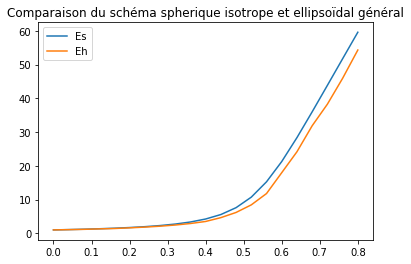

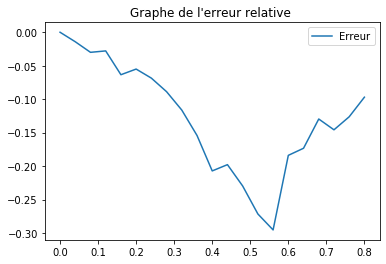

In [10]:
from classes_v2 import * 
fmax = 0.8
A = (1,1,1)
F,Eh,Nuh = compute_h_behavior2(A,fmax)

Em = 1
num = 0

Ef = 100
nuf = 0

inclusion_behavior = {"E":Ef, "nu":nuf}
matrix_behavior = {"E":Em, "nu":num}   

Ecalc = []

for i in range(len(F)):
    
    f_inclusion = F[i]  
    inclusion1 = Inclusion(0,inclusion_behavior)
    microstructure1 = Microstructure(matrix_behavior,{inclusion1 : f_inclusion})
    

    Ch=Autocoherent_Hill().compute_h_behavior(microstructure1)  
    Ecalc.append(Ch['E'])
    

plt.title("Comparaison du schéma spherique isotrope et ellipsoïdal général")
plt.plot(F,Ecalc,label='Es')
plt.plot(F,Eh,label='Eh')
plt.legend()
plt.show()

Ecalc = np.array(Ecalc)
Eh = np.array(Eh)
Erreur = (Eh-Ecalc)/Eh

plt.title("Graphe de l'erreur relative ")
plt.plot(F,Erreur,label='Erreur')
plt.legend()
plt.show()



## MODELE AUTOCOHERENT PLUSIEURS FORMES D'UNE MEME INCLUSION

In [11]:
def Mori_tanaka_multiple(Cm, inclusion_behaviors):
    
        """
        Calcule le comportement élastique homogène équivalent. 
        Renvoie un dict de comportement.
        Cm: (dict), dictionnaire du comportement de la matrice
        inclusion_behaviors(list), format [(Cf, f, aspect_ratio)] avec Cf les dictionnaires de comportement des inclusions et aspect_ratio un tuple contenant les deux valeurs de rapports de forme
        Ch = (Somme(fi*Ci*Ai)+(1-f)*Cm) * (Somme(fi*Ai)+(1-f)*I)**-1  avec Ai = (I+Esh*Sm*(Ci-Cm))**-1
        """
        
        n_renforts = 1000     # paramètre non physique qui permet de forcer lisotropie
        
        Sm = Cm['S']
        Cm = Cm['C']
        Id = np.identity(6) 
        
        # Calcul de fm
        fm = 1
        for i in range(len(inclusion_behaviors)) :   
            fm -= inclusion_behaviors[i][1]

        #Création des matrices de rotations
        Rotation_Op = Rotation_operator(n_renforts) 
        
        T = fm*Id
        
        W = np.zeros((6,6)) # Matrice f*C1:A1 des contributions de l'inclusion dans Ch
        
        for i in range(len(inclusion_behaviors)) :   
            Sfi = inclusion_behaviors[i][0]['S']
            Cfi = inclusion_behaviors[i][0]['C']
            fi = inclusion_behaviors[i][1]
            Ai = (1,inclusion_behaviors[i][2][0],inclusion_behaviors[i][2][0])
        
            fi_1_renfort = fi/n_renforts 
            
            Esh = Eshelby_tensor(Ai,Em,num)
            Aeshi = inv(Id + np.matmul(Esh,np.matmul(Sm,Cfi-Cm)))
            T += fi*Aeshi
            V6i = np.matmul(Cfi,Aeshi)
            clear_matrix2(V6i)
            # Ajout des contribution de chaque renfort en fonction de son orientation

            for j in range(n_renforts) :         
                V3 = Comp66_to_3333(V6i)
                V3R = Rotation_tenseur2(V3,Rotation_Op,j)
                V = Comp3333_to_66(V3R)
                W += fi_1_renfort * V

        Ch = np.matmul( (W + (1-f)*Cm) , inv(T))
        E = Young_isotropeC(Ch)
        nu = nu_isotropeC(Ch)

        return E,nu

    def compute_h_behavior_multi(Argument):
    
    n_renforts = 100     # paramètre non physique qui permet de forcer lisotropie
    n_pas = 2            # pas du modèle autocohérent
    precision = 10**-2  # précision désirée dans l'algorithme du point fixe
    

    # Création des matrices de comportement
    Em = 1
    num = 0
    Ef = 100
    nuf = 0
    
    Sm = Matrice_Souplesse_Isotrope(Em,num)
    Cm = inv(Sm)
    Sf = Matrice_Souplesse_Isotrope(Ef,nuf)
    Cf = inv(Sf)    
    Id = np.identity(6)
    
    #Initialisation du point fixe
    Cp = Cm
    Sp = Sm
    
    n_inclusions = len(Argument)
    A = np.zeros((n_inclusions,3))
    F = np.zeros(n_inclusions)
    for i in range(n_inclusions) : 
        A[i,:],F[i] = Argument[i]
    
    # Boucle d'incrémentation du pas
    for i in range(n_pas+1) : 
        F_pas = F*i/n_pas
        F_1_renfort = F_pas/n_renforts
        
        # Algorithme du point fixe : Ch=f(Ch) pour f fixé
        
        convergence = 2
        
        Eh = Young_isotrope(Sp)
        nuh = nu_isotrope(Sp)
        
        print('f_pas : ',F_pas)
        print('convergence',convergence)
        while convergence>precision :   
            W = np.zeros((6,6))           # Matrice des contributions de l'inclusion dans Ch
            # Boucle sur les différentes formes d'inclusions
            for j in range(n_inclusions) : 
                Esh = Eshelby_tensor(A[j],Eh,nuh)
                #print('Esh')
                #print(Esh)
                Aesh = inv(Id + np.matmul(Esh,np.matmul(Sp,Cf-Cp)))
                #print('Aesh')
                #print(Aesh)
                V6 = np.dot(Cf-Cm,Aesh)
                #print('V6')
                #print(V6)
                V3 = Comp66_to_3333(V6)
                # Ajout des contribution de chaque renfort en fonction de son orientation
                for i in range(n_renforts) : 
                    theta,phi,psi = Rot.random().as_euler('zxy', degrees=False)
                    #phi,theta,psi = Rotation_angles()
                    #phi,theta,psi = 0,0,0
                    V3R = Rotation_tenseur(V3,phi,theta,psi)
                    V = Comp3333_to_66(V3R)
                    W += F_1_renfort[j] * V
            #print('V3')
            #print(V3)
            #print('V3R')
            #print(V3R)
            #print('Rot')
            #print( Matrice_rotation(psi,phi,theta))
            #print('W')
            #print(W)
            Ch = Cm + W
            # Actualisation du matériau homogénéisé
            Cp = Ch
            Sp = inv(Cp)
            
            # Test de sortie
            E = Young_isotrope(Sp)
            nu = nu_isotrope(Sp)
            convergence = abs(E-Eh)
            #print('E', E,' nu',nu)
            #print('Eh', Eh,' nuh',nuh)
            print('convergence',convergence)
            Eh = E
            nuh = nu           
            
            # Forçage de la matrice en matrice isotrope
            Sp = Matrice_Souplesse_Isotrope(Eh,nuh)
            Cp = inv(Sp)
            
    return Cp


### TEST

In [7]:
A = (3,2,1)
f = 0.2/3
Argument = [(A,f),(A,f),(A,f)]
Ch = compute_h_behavior_multi(Argument)
print('Ch')
print(Ch)

f_pas :  [0. 0. 0.]
convergence 2
convergence 0.0
f_pas :  [0.03333333 0.03333333 0.03333333]
convergence 2
convergence 0.25320320496455695
convergence 0.05753770967945737
convergence 0.011696719720124982
convergence 0.003625280870453107
f_pas :  [0.06666667 0.06666667 0.06666667]
convergence 2
convergence 0.6570982804851093
convergence 0.12786100133259604
convergence 0.05771124285277485
convergence 0.022006576777925613
convergence 0.011842687250456452
convergence 0.004589859453542955
Ch
[[1.90686237 0.1632658  0.1632658  0.         0.         0.        ]
 [0.1632658  1.90686237 0.1632658  0.         0.         0.        ]
 [0.1632658  0.1632658  1.90686237 0.         0.         0.        ]
 [0.         0.         0.         0.87179829 0.         0.        ]
 [0.         0.         0.         0.         0.87179829 0.        ]
 [0.         0.         0.         0.         0.         0.87179829]]


# MODELE DE MORI-TANAKA

In [13]:
def Mori_tanaka(Cm, inclusion_behaviors):
    
        """
        Calcule le comportement élastique homogène équivalent. 
        Renvoie un dict de comportement.
        Cm: (dict), dictionnaire du comportement de la matrice
        inclusion_behaviors(list), format [(Cf, f, aspect_ratio)] avec Cf les dictionnaires de comportement des inclusions et aspect_ratio un tuple contenant les deux valeurs de rapports de forme
        """
        n_renforts = 1000     # paramètre non physique qui permet de forcer lisotropie
        
        Sm = Cm['S']
        Cm = Cm['C']
        Id = np.identity(6)  
        
        #Création des matrices de rotations
        Rotation_Op = Rotation_operator(n_renforts) 
        
        Sf = inclusion_behaviors[0][0]['S']
        Cf = inclusion_behaviors[0][0]['C']
        f = inclusion_behaviors[0][1]
        A = (1,inclusion_behaviors[0][2][0],inclusion_behaviors[0][2][0])

        f_1_renfort = f/n_renforts
        
        Esh = Eshelby_tensor(A,Em,num)
        Aesh = inv(Id + np.matmul(Esh,np.matmul(Sm,Cf-Cm)))
        Cmoy = np.zeros((6,6))
        ############################
        # Doit-on faire tourner Cf ? 
        ############################
        for j in range(n_renforts) :         
            Cf3 = Comp66_to_3333(Cf)
            Cf3R = Rotation_tenseur2(Cf3,Rotation_Op,j)
            Cmoy += Comp3333_to_66(Cf3R)
        Cmoy = Cmoy/n_renforts
        #Aesh = Id + np.matmul(Esh,np.matmul(Sm,Cmoy-Cm))
        ############################
        T = inv(f*Aesh + (1-f)*Id)
        V6 = np.matmul(Cf,Aesh)
        clear_matrix2(V6)
        W = np.zeros((6,6)) # Matrice f*C1:A1 des contributions de l'inclusion dans Ch

        # Ajout des contribution de chaque renfort en fonction de son orientation

        for j in range(n_renforts) :         
            V3 = Comp66_to_3333(V6)
            V3R = Rotation_tenseur2(V3,Rotation_Op,j)
            V = Comp3333_to_66(V3R)
            W += f_1_renfort * V
            
        Ch = np.matmul( (W + (1-f)*Cm) , T)
 
        E = Young_isotropeC(Ch)
        nu = nu_isotropeC(Ch)

        return E,nu
    

    
def Mori_tanaka_multiple(Cm, inclusion_behaviors):
    
        """
        Calcule le comportement élastique homogène équivalent. 
        Renvoie un dict de comportement.
        Cm: (dict), dictionnaire du comportement de la matrice
        inclusion_behaviors(list), format [(Cf, f, aspect_ratio)] avec Cf les dictionnaires de comportement des inclusions et aspect_ratio un tuple contenant les deux valeurs de rapports de forme
        Ch = (Somme(fi*Ci*Ai)+(1-f)*Cm) * (Somme(fi*Ai)+(1-f)*I)**-1  avec Ai = (I+Esh*Sm*(Ci-Cm))**-1
        """
        
        n_renforts = 100     # paramètre non physique qui permet de forcer lisotropie
        
        Sm = Cm['S']
        Cm = Cm['C']
        Id = np.identity(6) 
        
        # Calcul de fm
        fm = 1
        for i in range(len(inclusion_behaviors)) :   
            fm -= inclusion_behaviors[i][1]

        #Création des matrices de rotations
        Rotation_Op = Rotation_operator(n_renforts) 
        
        T = fm*Id
        
        W = np.zeros((6,6)) # Matrice f*C1:A1 des contributions de l'inclusion dans Ch
        
        for i in range(len(inclusion_behaviors)) :   
            Sfi = inclusion_behaviors[i][0]['S']
            Cfi = inclusion_behaviors[i][0]['C']
            fi = inclusion_behaviors[i][1]
            Ai = (1,inclusion_behaviors[i][2][0],inclusion_behaviors[i][2][0])
        
            fi_1_renfort = fi/n_renforts 
            
            Esh = Eshelby_tensor(Ai,Em,num)
            Aeshi = inv(Id + np.matmul(Esh,np.matmul(Sm,Cfi-Cm)))
            T += fi*Aeshi
            V6i = np.matmul(Cfi,Aeshi)
            clear_matrix2(V6i)
            # Ajout des contribution de chaque renfort en fonction de son orientation

            for j in range(n_renforts) :         
                V3 = Comp66_to_3333(V6i)
                V3R = Rotation_tenseur2(V3,Rotation_Op,j)
                V = Comp3333_to_66(V3R)
                W += fi_1_renfort * V

        Ch = np.matmul( (W + fm*Cm) , inv(T))
        E = Young_isotropeC(Ch)
        nu = nu_isotropeC(Ch)

        return E,nu

### Comparaison sphères isotropes

f= 0.0
f= 0.11
f= 0.22
f= 0.33
f= 0.44
f= 0.55
f= 0.66
f= 0.77
f= 0.88
f= 0.99


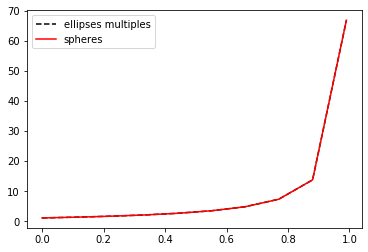

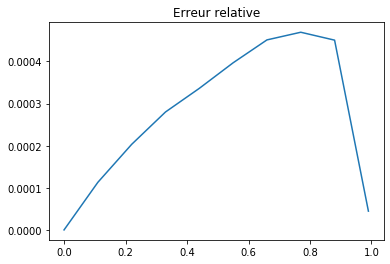

In [18]:
Ef,Em = 100,1
nuf,num = 0.3,0.3
ar = (1,1)
Sm = Matrice_Souplesse_Isotrope(Em,num)
Cm = inv(Sm)

Sf = Matrice_Souplesse_Isotrope(Ef,nuf)
Cf = inv(Sf)

inclusion_behavior = {'C':Cf , 'S':Sf}
matrix_behavior = {'C': Cm, 'S': Sm}

inclusion_behavior2 = {'E':Ef , 'nu':nuf}
matrix_behavior2 = {'E': Em, 'nu': num}

inclusion = Inclusion(0,inclusion_behavior2)

F = np.linspace(0,0.99,10)
LE1,LE2,LE3,LEr = [],[],[],[]

for i in range(len(F)) : 
    f = F[i]
    print("f=",f)
    microstructure = Microstructure(matrix_behavior2,{inclusion : f})
    
    E2,nu2 = Mori_tanaka_multiple(matrix_behavior,[(inclusion_behavior,f,ar)])
    E3 = Mori_Tanaka().compute_h_behavior(microstructure)['E']
    Er = (E2-E3)/E3
    
    
    LE2.append(E2)
    LE3.append(E3)
    LEr.append(Er)


plt.plot(F,LE2,'--k',label = "ellipses multiples")
plt.plot(F,LE3,'r',label = "spheres")
plt.legend()
plt.show()

plt.plot(F,LEr)
plt.title("Erreur relative")
plt.show()


### Faire tourner Cf dans A ou non 

In [11]:
def Mori_tanaka_multiple_oui(Cm, inclusion_behaviors):
    
        """
        Calcule le comportement élastique homogène équivalent. 
        Renvoie un dict de comportement.
        Cm: (dict), dictionnaire du comportement de la matrice
        inclusion_behaviors(list), format [(Cf, f, aspect_ratio)] avec Cf les dictionnaires de comportement des inclusions et aspect_ratio un tuple contenant les deux valeurs de rapports de forme
        Ch = (Somme(fi*Ci*Ai)+(1-f)*Cm) * (Somme(fi*Ai)+(1-f)*I)**-1  avec Ai = (I+Esh*Sm*(Ci-Cm))**-1
        """
        
        n_renforts = 100     # paramètre non physique qui permet de forcer lisotropie
        
        Sm = Cm['S']
        Cm = Cm['C']
        Id = np.identity(6) 
        
        # Calcul de fm
        fm = 1
        for i in range(len(inclusion_behaviors)) :   
            fm -= inclusion_behaviors[i][1]

        #Création des matrices de rotations
        Rotation_Op = Rotation_operator(n_renforts) 
        
        T = fm*Id
        
        W = np.zeros((6,6)) # Matrice f*C1:A1 des contributions de l'inclusion dans Ch
        
        for i in range(len(inclusion_behaviors)) :   
            Sfi = inclusion_behaviors[i][0]['S']
            Cfi = inclusion_behaviors[i][0]['C']
            fi = inclusion_behaviors[i][1]
            Ai = (1,inclusion_behaviors[i][2][0],inclusion_behaviors[i][2][0])
        
            fi_1_renfort = fi/n_renforts 
            
            Esh = Eshelby_tensor(Ai,Em,num)
            T = fm*Id
            # Ajout des contribution de chaque renfort en fonction de son orientation

            for j in range(n_renforts) : 
                CfiR = Comp3333_to_66(Rotation_tenseur2(Comp66_to_3333(Cfi),Rotation_Op,j))
                AeshiR = inv(Id + np.matmul(Esh,np.matmul(Sm,CfiR-Cm)))
                T += fi_1_renfort*AeshiR
                V6i = np.matmul(CfiR,AeshiR)
                clear_matrix2(V6i)
                W += fi_1_renfort * V6i

        Ch = np.matmul( (W + fm*Cm) , inv(T))
        E = Young_isotropeC(Ch)
        nu = nu_isotropeC(Ch)

        return E,nu

def Mori_tanaka_multiple_non(Cm, inclusion_behaviors):
    
        """
        Calcule le comportement élastique homogène équivalent. 
        Renvoie un dict de comportement.
        Cm: (dict), dictionnaire du comportement de la matrice
        inclusion_behaviors(list), format [(Cf, f, aspect_ratio)] avec Cf les dictionnaires de comportement des inclusions et aspect_ratio un tuple contenant les deux valeurs de rapports de forme
        Ch = (Somme(fi*Ci*Ai)+(1-f)*Cm) * (Somme(fi*Ai)+(1-f)*I)**-1  avec Ai = (I+Esh*Sm*(Ci-Cm))**-1
        """
        
        n_renforts = 100     # paramètre non physique qui permet de forcer lisotropie
        
        Sm = Cm['S']
        Cm = Cm['C']
        Id = np.identity(6) 
        
        # Calcul de fm
        fm = 1
        for i in range(len(inclusion_behaviors)) :   
            fm -= inclusion_behaviors[i][1]

        #Création des matrices de rotations
        Rotation_Op = Rotation_operator(n_renforts) 
        
        T = fm*Id
        
        W = np.zeros((6,6)) # Matrice f*C1:A1 des contributions de l'inclusion dans Ch
        
        for i in range(len(inclusion_behaviors)) :   
            Sfi = inclusion_behaviors[i][0]['S']
            Cfi = inclusion_behaviors[i][0]['C']
            fi = inclusion_behaviors[i][1]
            Ai = (1,inclusion_behaviors[i][2][0],inclusion_behaviors[i][2][0])
        
            fi_1_renfort = fi/n_renforts 
            
            Esh = Eshelby_tensor(Ai,Em,num)
            Aeshi = inv(Id + np.matmul(Esh,np.matmul(Sm,Cfi-Cm)))
            T += fi*Aeshi
            V6i = np.matmul(Cfi,Aeshi)
            clear_matrix2(V6i)
            # Ajout des contribution de chaque renfort en fonction de son orientation

            for j in range(n_renforts) :         
                V3 = Comp66_to_3333(V6i)
                V3R = Rotation_tenseur2(V3,Rotation_Op,j)
                V = Comp3333_to_66(V3R)
                W += fi_1_renfort * V

        Ch = np.matmul( (W + fm*Cm) , inv(T))
        E = Young_isotropeC(Ch)
        nu = nu_isotropeC(Ch)

        return E,nu

In [12]:
from classes2 import *

Ef,Em = 100,1
nuf,num = 0.3,0.3
ar = (1,1)
Sm = Matrice_Souplesse_Isotrope(Em,num)
Cm = inv(Sm)

Sf = Matrice_Souplesse_Isotrope(Ef,nuf)
Cf = inv(Sf)

inclusion_behavior = {'C':Cf , 'S':Sf}
matrix_behavior = {'C': Cm, 'S': Sm}

inclusion_behavior2 = {'E':Ef , 'nu':nuf}
matrix_behavior2 = {'E': Em, 'nu': num}

inclusion = Inclusion(0,inclusion_behavior2)

F = np.linspace(0,0.99,5)
LE1,LE2,LE3,LEr = [],[],[],[]

for i in range(len(F)) : 
    f = F[i]
    print("f=",f)
    microstructure = Microstructure(matrix_behavior2,{inclusion : f})
    
    print(Mori_tanaka_multiple_oui(matrix_behavior,[(inclusion_behavior,f,ar)]))
    print(Mori_tanaka_multiple_non(matrix_behavior,[(inclusion_behavior,f,ar)]))

f= 0.0
(1.0, 0.3)
(1.0, 0.3)
f= 0.2475
(1.6503156835817576, 0.2829428715746935)
(1.6501858659783435, 0.28292488400588506)
f= 0.495
(2.9093530386384288, 0.2705121820413434)
(2.909002494417406, 0.27048366192305906)
f= 0.7424999999999999
(6.405924578917924, 0.2620783540178645)
(6.404698986551487, 0.26203224002500136)
f= 0.99
(66.78420564326198, 0.28383844564490224)
(66.77137172754696, 0.2837981050473032)


### VERSION PROPRE : AUTOCOHERENT INCLUSIONS DE FORMES ET COMPORTEMENT DIFFERENTS

In [46]:
from scipy.spatial.transform import Rotation as Rot
        
def Autocoherent_multiple(Cm, inclusion_behaviors):
    # Paramètres internes du modèles         
    n_renforts = 1000     # paramètre non physique qui permet de forcer l'isotropie
    n_points_fixe = 90   # précise le pas de dilution (pour l'initialisation du point fixe)
    precision = 10**-2  # précision désirée dans l'algorithme du point fixe

    Sm = Cm['S']
    Cm = Cm['C']
    Id = np.identity(6) 
    n_inclusions = len(inclusion_behaviors)
    
    ######### POUR LE TEST UNIQUEMENT #########
    f = inclusion_behaviors[0][1]
    LE = []
    F = []
    ###########################################

    #Création des matrices de rotations
    Rotation_Op = Rotation_operator(n_renforts)         

    #Initialisation du point fixe
    Cp = Cm
    Sp = Sm

    # Boucle d'incrémentation de la fraction volumique
    for i in range(n_points_fixe+1) :
        # Algorithme du point fixe : Ch=f(Ch) pour f fixé

        convergence = 2

        Eh = Young_isotrope(Sp)
        nuh = nu_isotrope(Sp)
        print(i," pas sur ",n_points_fixe,'en cours')
        print('convergence',convergence)
        while convergence>precision :   
            W = np.zeros((6,6))           # Matrice des contributions de l'inclusion dans Ch

            # Boucle sur les différentes formes d'inclusions
            for j in range(n_inclusions) : 
                Cf = inclusion_behaviors[j][0]['C']
                a2,a3 = inclusion_behaviors[j][2]
                A = 1,a2,a3
                Esh = Eshelby_tensor(A,Eh,nuh)
                Aesh = inv(Id + np.matmul(Esh,np.matmul(Sp,Cf-Cp)))
                V6 = np.dot(Cf-Cm,Aesh)
                V3 = Comp66_to_3333(V6)

                # Ajout des contribution de chaque renfort en fonction de son orientation
                for k in range(n_renforts) :                    
                    V3R = Rotation_tenseur2(V3,Rotation_Op,j)
                    V = Comp3333_to_66(V3R)
                    W += inclusion_behaviors[j][1]*i/(n_points_fixe*n_renforts) * V
            Ch = Cm + W

            # Actualisation du matériau homogénéisé
            Cp = Ch

            # Test de sortie
            E = Young_isotropeC(Cp)
            nu = nu_isotropeC(Cp)
            convergence = abs(E-Eh)/Eh

            print('convergence',convergence)
            Eh = E
            nuh = nu           

            # Forçage de la matrice en matrice isotrope
            Sp = Matrice_Souplesse_Isotrope(Eh,nuh)
            Cp = inv(Sp)
            
        LE.append(Eh)
        F.append(f*i/n_points_fixe)

    return LE,F

0  pas sur  90 en cours
convergence 2
convergence 0.0
1  pas sur  90 en cours
convergence 2
convergence 0.01995457108480947
convergence 0.00038431917925001304
2  pas sur  90 en cours
convergence 2
convergence 0.019950918213412192
convergence 0.0007679828138999011
3  pas sur  90 en cours
convergence 2
convergence 0.019962028345938562
convergence 0.001151802541824819
4  pas sur  90 en cours
convergence 2
convergence 0.019987854474502267
convergence 0.0015365828770686702
5  pas sur  90 en cours
convergence 2
convergence 0.02002840998636799
convergence 0.0019231264817986195
6  pas sur  90 en cours
convergence 2
convergence 0.020083767830438255
convergence 0.0023122392890932626
7  pas sur  90 en cours
convergence 2
convergence 0.020154060237684967
convergence 0.002704735539543259
8  pas sur  90 en cours
convergence 2
convergence 0.02023947897009293
convergence 0.0031014427894806127
9  pas sur  90 en cours
convergence 2
convergence 0.02034027608042435
convergence 0.0035032069441548507
10  pa

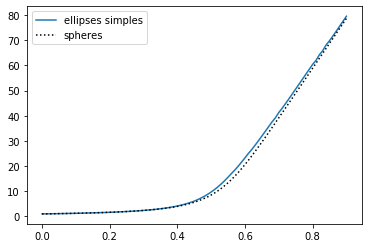

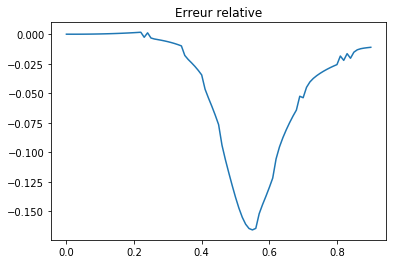

In [47]:
from classes_v2 import * 

Ef,Em = 100,1
nuf,num = 0.3,0.3
f = 0.9
ar = (1,1)

Sm = Matrice_Souplesse_Isotrope(Em,num)
Cm = inv(Sm)
Sf = Matrice_Souplesse_Isotrope(Ef,nuf)
Cf = inv(Sf)

inclusion_behavior = {'C':Cf , 'S':Sf}
matrix_behavior = {'C': Cm, 'S': Sm}

inclusion_behavior2 = {'E':Ef , 'nu':nuf}
matrix_behavior2 = {'E': Em, 'nu': num}

EH,Fh = Autocoherent_multiple(matrix_behavior,[(inclusion_behavior,f,ar)])


inclusion = Inclusion(0,inclusion_behavior2)
LE1,LEr = [],[]

for i in range(len(Fh)) : 
    f = Fh[i]
    microstructure = Microstructure(matrix_behavior2,{inclusion : f})
    E1 = Autocoherent_Hill().compute_h_behavior(microstructure)['E']
    Er = (E1-EH[i])/E1
    
    
    LE1.append(E1)
    LEr.append(Er)
    
plt.plot(Fh,EH,label = "ellipses simples")
plt.plot(Fh,LE1,':k',label = "spheres")
plt.legend()
plt.show()

plt.plot(Fh,LEr)
plt.title("Erreur relative")
plt.show()

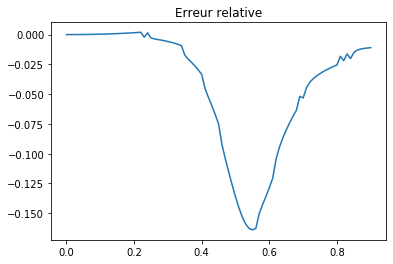

In [45]:
plt.plot(Fh,LEr)
plt.title("Erreur relative")
plt.show()